# **Introduction**

Air pollution is affected by the weather due to the moisture and the precipitation of the air affecting the concentration of pollutants through factors such as humidity, temperature, and particulate matter. For example, when it rains, particulate matter such as PM 2.5 is carried out of the air through rain droplets into groundwater, and gaseous pollutants may dissolve into the water. 

We’re choosing the air particles PM 2.5 because the variable frequently emerges in regards to the air pollution in Beijing, specifically the region Tiantan because of its population consisting of both locals and tourists creating a generous amount of people to be affected by. Through this data analysis, we can predict the air condition in the region and the impact it has on the community and how we can further improve it. 

In this project, we will aim to predict the concentration of the air particles PM 2.5 based on the weather which is decided by 5 variables (the temperature (C°), pressure (hPa), dew point temperature (C°), precipitation (mm), wind speed (m/s)). A question that may come up within this prediction would relate to **how does the weather affect the concentration of pollutant PM 2.5 ?**

The dataset itself consists of hourly concentration of air pollutants and meteorological variables from 12 air-monitoring stations in Beijing between March 1, 2013 and February 28, 2017. 

# **Methods**

The object that we are going to predict in this data set is the pollutant PM 2.5 with the 5 predictors we're planning to apply which are Temperature (TEMP), Pressure (PRES), Dew Point Temperature (DEWP), Rain (RAIN). and Wind Speed (WSPM). We will perform a KNN regression on the data and analyze the strength of the effect that weather has on the concentration of pollutants. 

In the original data set, there is a variable called Wind Direction (wd) in which we will not take into consideration within the prediction since it is a categorical variable therefore is not integrated with the plot.

Additionally, seasonal weather may influence the prediction, however this is not our topic of study. Therefore all time variables such as year, month, day, hour are dropped to prevent interference with our regression plot although we will attempt to group the data points by year, month, and day.

We plan normalize our data to make sure that certain variables with large absolute quantities such as PM 2.5 do not receive undue weight.

In conclusion, the variables used for the data set are as such :
1. Objects for Regression: PM 2.5 
 
2. Predictors: 
- Temperature (TEMP) 
- Pressure (PRES) 
- Dew Point Temperature (DEWP) 
- Rain (RAIN) 
- Wind Speed (WSPM) 

We will visualize the results through a regression plot on pollutants such as PM 2.5 in which we will create separate regression plots for each predictor in relation to our pollutant.

## **Code**

### 1. Load the Library and Data

In [1]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(testthat)
library(digest)
library(tidymodels)
library(GGally)
library(broom)
library(infer)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
weather_data <- read.csv("https://www.dropbox.com/s/2vo6d6ynrsxpavp/PRSA_Data_Tiantan_20130301-20170228.csv?dl=1")
weather_data

No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,2013,3,1,0,6,6,4,8,300,81,-0.5,1024.5,-21.4,0,NNW,5.7,Tiantan
2,2013,3,1,1,6,29,5,9,300,80,-0.7,1025.1,-22.1,0,NW,3.9,Tiantan
3,2013,3,1,2,6,6,4,12,300,75,-1.2,1025.3,-24.6,0,NNW,5.3,Tiantan
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35062,2017,2,28,21,18,32,4,48,500,48,10.8,1014.2,-13.3,0,NW,1.1,Tiantan
35063,2017,2,28,22,15,42,5,52,600,44,10.5,1014.4,-12.9,0,NNW,1.2,Tiantan
35064,2017,2,28,23,15,50,5,68,700,21,8.6,1014.1,-15.9,0,NNE,1.3,Tiantan


### 2. Tidy the Data

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3250000,1028.783,-21.46667,0,3.3083333,8.62500
0.4916667,1028.850,-16.96250,0,0.7916667,31.70833
4.9875000,1016.458,-12.31250,0,1.2250000,98.04167
⋮,⋮,⋮,⋮,⋮,⋮
7.245833,1018.812,-10.754167,0,1.825000,10.20833
7.208333,1020.337,-8.258333,0,1.566667,24.16667
10.958333,1014.888,-12.783333,0,2.058333,14.87500


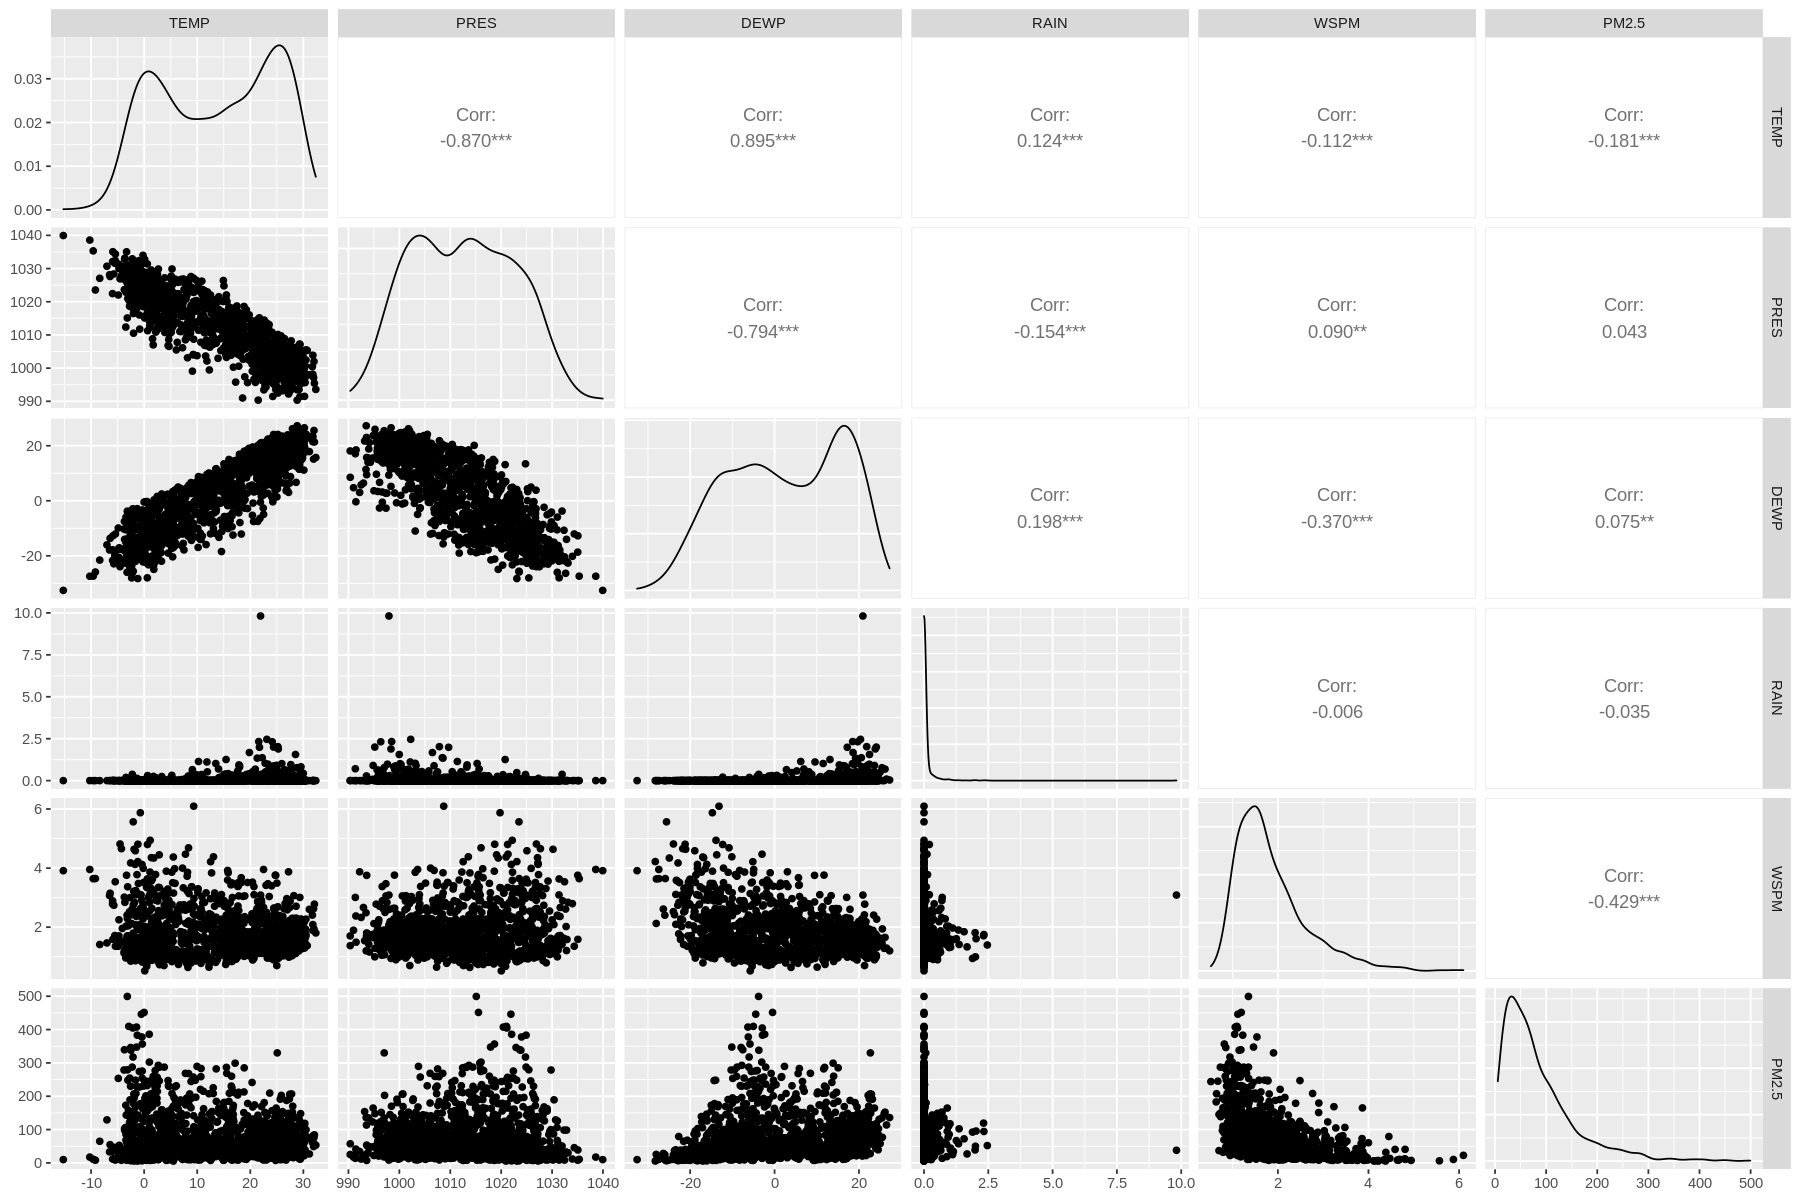

In [3]:
tidy_data <- weather_data |> group_by(year, month, day) |> 
summarize(TEMP = mean(TEMP), PRES = mean(PRES), DEWP = mean(DEWP), RAIN = mean(RAIN), WSPM = mean(WSPM), PM2.5 = mean(PM2.5)) |> ungroup() |> select(-year, -month, -day) |> na.omit()

options(repr.plot.height = 10, repr.plot.width = 15)
tidy_data
ggpairs(tidy_data)

In [4]:
# create an empty tibble to store the results
names <- colnames(tidy_data |> select(-PM2.5))
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     rmse = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("regression")

# create a 5-fold cross-validation object
weather_vfold <- vfold_cv(tidy_data, v = 5, strata = PM2.5)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("PM2.5", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        weather_recipe <- recipe(as.formula(model_string), 
                                data = tidy_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        
        # tune the KNN regression model with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
            add_recipe(weather_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = weather_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "rmse") |>
            summarize(mx = min(mean))
            acc <- acc$mx |> unlist()
        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
        
    }
    jstar <- which.min(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              rmse = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,rmse
<int>,<chr>,<dbl>
1,PM2.5 ~ WSPM,62.34372
2,PM2.5 ~ WSPM+DEWP,57.61767
3,PM2.5 ~ WSPM+DEWP+TEMP,52.73731
4,PM2.5 ~ WSPM+DEWP+TEMP+PRES,50.30264
5,PM2.5 ~ WSPM+DEWP+TEMP+PRES+RAIN,49.74308


After we loaded and the tidied up the data set in R, we decided to visualize it with the *ggpairs* function. Here we see in these graphs that the relationship between the object of prediction, PM2.5 and its 5 predictors *Temperature, Pressure, Dew Point, Rain, and Wind Speed* vary, with each variable also having its own relationship with one another. We can take a look specifically on the last row where there's a direct relationship between the variable PM2.5 with its predictors.

On the final row, we can see that as the values of PM2.5 increases, the predictors have the relationships as such :
- The variable Temperature has a sudden jump in the beginning and then decreases to then remain stable throughout the rest of the graph.
- The variable Pressure has a stable rate throughout the graph with a few values increasing towards the middle-end.
- The variable Dew Point increases relatively fast until the middle of the graph where the values are at its peak as it decreases after to reach a stable rate.
- The variable Rain has a spike with a peak at the very beginning of the graph, proceeds to drop to a small value and decreases to 0 throughout the rest of the graph. Additionally, there's a singular value by the end of it.
- The variable Wind Speed starts immediately at a high point of the graph increasing towards its peak and has a stable decrease until the end of the graph.

### 3. KNN Regression

#### **A.  Split the Data, Create a Training and a Testing Data**

In [5]:
set.seed(2000) 

weather_split <- initial_split(tidy_data, prop = 0.75, strata = PM2.5)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)

In [6]:
#Table 1.1 Training Weather Data 
weather_training

TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3250000,1028.783,-21.46667,0,3.3083333,8.62500
0.4916667,1028.850,-16.96250,0,0.7916667,31.70833
10.5625000,1019.454,-14.00000,0,2.5041667,22.33333
⋮,⋮,⋮,⋮,⋮,⋮
-1.420347,1017.919,-10.13333,0,1.4625000,347.4167
-0.575000,1019.250,-14.21667,0,0.9333333,178.0000
1.550000,1022.638,-12.79167,0,1.1083333,134.8333


In [7]:
#Table 1.2 Testing Weather Data 
weather_testing

TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.104167,1010.796,1.120833,0.2208333,1.179167,126.9583
3.962500,1023.471,-4.991667,0.0000000,1.858333,83.8750
5.866667,1016.388,-1.320833,0.0000000,0.937500,189.7083
⋮,⋮,⋮,⋮,⋮,⋮
1.541667,1016.742,-5.829167,0,0.8791667,208.29167
3.729167,1024.321,-12.325000,0,2.0291667,20.83333
7.208333,1020.337,-8.258333,0,1.5666667,24.16667


#### **B.  Create K-Nearest Neighbor Specification and Recipe**

In [9]:
#Perform KNN regression on CO using the predictor Wind_Speed
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("regression")

weather_recipe <- recipe(PM2.5 ~ WSPM, data = weather_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
    
weather_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

#### **C.  Create Workflow using the Previously Made Recipe and Specification**

In [13]:
set.seed(2000) 
weather_vfold <- vfold_cv(weather_training, v = 5, strata = PM2.5)

weather_workflow <- workflow() |>
                    add_recipe(weather_recipe) |>
                    add_model(weather_spec)

weather_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### **D.  Results of Workflow Computation and Finding the Best K-Nearest Neighbour Values**

In [14]:
set.seed(2000)

gridvals <- tibble(neighbors = seq(from = 1, to = 200))

weather_results <- weather_workflow|> 
                  tune_grid(resamples = weather_vfold, grid = gridvals) |>
                  collect_metrics()
weather_results 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,88.75905511,5,4.9791208,Preprocessor1_Model001
1,rsq,standard,0.04781377,5,0.0179823,Preprocessor1_Model001
2,rmse,standard,77.99992758,5,4.9505166,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rsq,standard,0.2560251,5,0.01918757,Preprocessor1_Model199
200,rmse,standard,62.4486854,5,4.45938832,Preprocessor1_Model200
200,rsq,standard,0.2562357,5,0.01910633,Preprocessor1_Model200


In [15]:
#Table 2.1 Weather Workflow Data Results
weather_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,88.75905511,5,4.9791208,Preprocessor1_Model001
1,rsq,standard,0.04781377,5,0.0179823,Preprocessor1_Model001
2,rmse,standard,77.99992758,5,4.9505166,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rsq,standard,0.2560251,5,0.01918757,Preprocessor1_Model199
200,rmse,standard,62.4486854,5,4.45938832,Preprocessor1_Model200
200,rsq,standard,0.2562357,5,0.01910633,Preprocessor1_Model200


In [16]:
weather_min <- weather_results |>
            filter(.metric == "rmse") |>
            arrange(mean) |> 
            slice(n = 1)
            
weather_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
107,rmse,standard,61.80509,5,4.439093,Preprocessor1_Model107


In [17]:
#Table 2.2 Weather with Best K-Nearest Neighbours and Estimation Values
weather_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
107,rmse,standard,61.80509,5,4.439093,Preprocessor1_Model107


#### **E.  Repetition of Specification and Workflow Computation using the Results Concluded**

In [19]:
k_min <- weather_min |>
          pull(neighbors)
k_min


weather_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                    set_engine("kknn") |>
                    set_mode("regression")

weather_best_fit <- workflow() |>
                    add_recipe(weather_recipe) |>
                    add_model(weather_best_spec) |>
                    fit(data = weather_training)

weather_summary <- weather_best_fit |>
                    predict(weather_testing) |>
                    bind_cols(weather_testing) |>
                    metrics(truth = PM2.5, estimate = .pred) |>
                    filter(.metric == "rmse")

weather_summary

[1] 107

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,55.04526


#### **F.  Produce the Calculated Predicted Values against The Object of Prediction itself (PM2.5):** *Using the Trained Workflow on a new unseen Dataset (Testing Weather Data)*

In [20]:
weather_preds <- weather_best_fit |>
                predict(weather_testing) |>
                bind_cols(weather_testing)

In [21]:
weather_preds

.pred,TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
125.09505,5.104167,1010.796,1.120833,0.2208333,1.179167,126.9583
72.89139,3.962500,1023.471,-4.991667,0.0000000,1.858333,83.8750
155.94782,5.866667,1016.388,-1.320833,0.0000000,0.937500,189.7083
⋮,⋮,⋮,⋮,⋮,⋮,⋮
160.61254,1.541667,1016.742,-5.829167,0,0.8791667,208.29167
61.71924,3.729167,1024.321,-12.325000,0,2.0291667,20.83333
74.34229,7.208333,1020.337,-8.258333,0,1.5666667,24.16667


#### **G.  Visualization of Predicted Values on every Predictor**

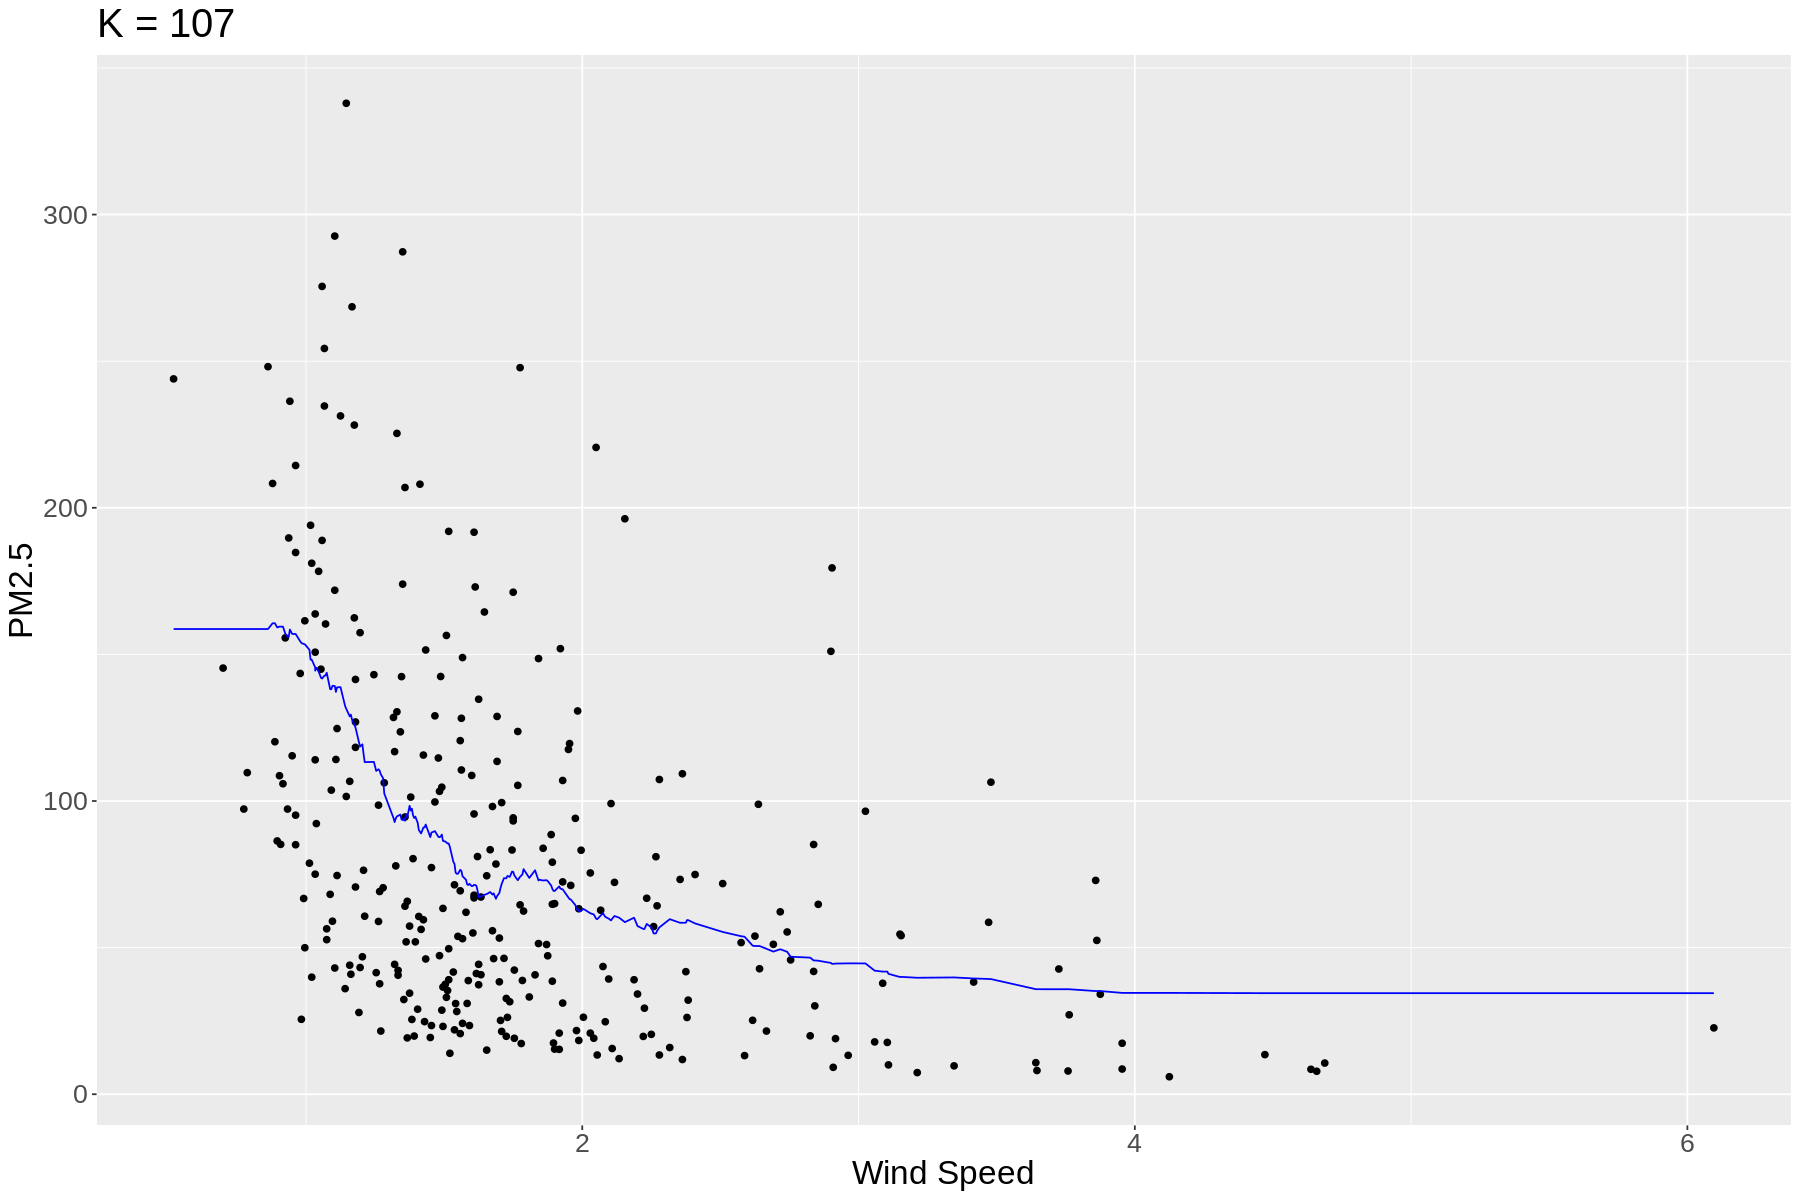

In [25]:
weather_plot <- ggplot(weather_preds, aes(x = WSPM, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = WSPM, y = .pred),
              color = "blue") +
    xlab("Wind Speed") + 
    ylab("PM2.5") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

weather_plot

**ELABORATE**

### Discussion

1. Summarize what you found

....


2. Discuss whether this is what you expected to find?

- What do you expect to find?

We expect to find a correlation between certain meteorological conditions (temperature, dew point temperature, pressure, precipitation, wind speed) and the quantity of certain air pollutants (PM2.5) and examine which predictor has the strongest correlation with the object  so that it would be the best one for making the prediction. For example, temperature has the greatest correlation with PM2.5, then it should be the best predictor among the 5 predictors we have and we should use that one for predicting the unknown PM2.5 concentrations.

- What we found

....

3. What impact could such findings have?

Discovering the relationship between air pollutants and weather conditions may provide insight into methods of mitigating the effects of air pollution. This can help to advance active pollution reduction technologies such as carbon capture or discovering better methods of reducing the penetration of PM 2.5 into households. Since we can tentatively predict the weather, we may be able to use meteorology combined with behavioral techniques to reduce air pollution such as by using green energy during periods of low wind speed.

4. What future questions could this lead to?

- Is the air pollution temporarily reduced or permanently removed from the air through weather events?
**The pollutant, PM 2.5, may be integrated into the environment such as how smoke is washed into the soil and turned into ash.**

- Does the pollution from air pollution become integrated into the environment through other means such as water pollution?
**Certain types of toxic pollutants may be washed into the water supply, such as meteorological conditions such as acid rain.**

- How might meteorological conditions be stimulated or controlled to reduce air pollution in cities?
**Techniques such as rain cloud seeding may be available to reduce the concentration of pollutants during high concentration of pollutants.**

### References